In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 32
EPOCHS = 300
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                
def resample_data1(directory, target_count=300):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)

In [4]:
# Resample training data
resample_data(train_dir)
resample_data1(val_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)


Found 3500 images belonging to 7 classes.
Found 2100 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 600, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 600, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 300, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 300, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 300, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 150, 112, 128)     0     

In [6]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [7]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback],
    verbose=2
)

Epoch 1/300
66/66 [==============================] - 29s 448ms/step
Epoch 1 - Validation Loss: 1.9383, Validation Accuracy: 0.1633, Validation Precision: 0.0954
110/110 - 177s - loss: 1.9876 - acc: 0.1514 - val_loss: 1.9383 - val_acc: 0.1633 - 177s/epoch - 2s/step
Epoch 2/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 444ms/step
Epoch 2 - Validation Loss: 1.9240, Validation Accuracy: 0.1590, Validation Precision: 0.0771
110/110 - 154s - loss: 1.9395 - acc: 0.1657 - val_loss: 1.9240 - val_acc: 0.1590 - 154s/epoch - 1s/step
Epoch 3/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 443ms/step
Epoch 3 - Validation Loss: 1.8596, Validation Accuracy: 0.2867, Validation Precision: 0.1190
110/110 - 153s - loss: 1.9185 - acc: 0.1863 - val_loss: 1.8596 - val_acc: 0.2867 - 153s/epoch - 1s/step
Epoch 4/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 444ms/step
Epoch 4 - Validation Loss: 1.8039, Validation Accuracy: 0.2595, Validation Precision: 0.0860
110/110 - 152s - loss: 1.8627 - acc: 0.2220 - val_loss: 1.8039 - val_acc: 0.2595 - 152s/epoch - 1s/step
Epoch 5/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 443ms/step
Epoch 5 - Validation Loss: 1.7754, Validation Accuracy: 0.2738, Validation Precision: 0.1973
110/110 - 153s - loss: 1.8236 - acc: 0.2451 - val_loss: 1.7754 - val_acc: 0.2738 - 153s/epoch - 1s/step
Epoch 6/300
66/66 [==============================] - 29s 443ms/step
Epoch 6 - Validation Loss: 1.7598, Validation Accuracy: 0.2629, Validation Precision: 0.1500
110/110 - 152s - loss: 1.7976 - acc: 0.2449 - val_loss: 1.7598 - val_acc: 0.2629 - 152s/epoch - 1s/step
Epoch 7/300
66/66 [==============================] - 29s 443ms/step
Epoch 7 - Validation Loss: 1.7529, Validation Accuracy: 0.2838, Validation Precision: 0.0978
110/110 - 153s - loss: 1.7709 - acc: 0.2580 - val_loss: 1.7529 - val_acc: 0.2838 - 153s/epoch - 1s/step
Epoch 8/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 443ms/step
Epoch 8 - Validation Loss: 1.7460, Validation Accuracy: 0.2933, Validation Precision: 0.1461
110/110 - 153s - loss: 1.7580 - acc: 0.2614 - val_loss: 1.7460 - val_acc: 0.2933 - 153s/epoch - 1s/step
Epoch 9/300
66/66 [==============================] - 29s 442ms/step
Epoch 9 - Validation Loss: 1.6894, Validation Accuracy: 0.3248, Validation Precision: 0.1155
110/110 - 152s - loss: 1.7444 - acc: 0.2737 - val_loss: 1.6894 - val_acc: 0.3248 - 152s/epoch - 1s/step
Epoch 10/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 443ms/step
Epoch 10 - Validation Loss: 1.7192, Validation Accuracy: 0.3152, Validation Precision: 0.1614
110/110 - 153s - loss: 1.7333 - acc: 0.2837 - val_loss: 1.7192 - val_acc: 0.3152 - 153s/epoch - 1s/step
Epoch 11/300
66/66 [==============================] - 29s 442ms/step
Epoch 11 - Validation Loss: 1.6655, Validation Accuracy: 0.3129, Validation Precision: 0.1177
110/110 - 152s - loss: 1.7267 - acc: 0.2837 - val_loss: 1.6655 - val_acc: 0.3129 - 152s/epoch - 1s/step
Epoch 12/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 443ms/step
Epoch 12 - Validation Loss: 1.7293, Validation Accuracy: 0.2957, Validation Precision: 0.1730
110/110 - 153s - loss: 1.7210 - acc: 0.2814 - val_loss: 1.7293 - val_acc: 0.2957 - 153s/epoch - 1s/step
Epoch 13/300
66/66 [==============================] - 29s 442ms/step
Epoch 13 - Validation Loss: 1.6946, Validation Accuracy: 0.3371, Validation Precision: 0.1265
110/110 - 152s - loss: 1.7135 - acc: 0.2854 - val_loss: 1.6946 - val_acc: 0.3371 - 152s/epoch - 1s/step
Epoch 14/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 444ms/step
Epoch 14 - Validation Loss: 1.6585, Validation Accuracy: 0.3548, Validation Precision: 0.1135
110/110 - 153s - loss: 1.6971 - acc: 0.3029 - val_loss: 1.6585 - val_acc: 0.3548 - 153s/epoch - 1s/step
Epoch 15/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 443ms/step
Epoch 15 - Validation Loss: 1.6734, Validation Accuracy: 0.3324, Validation Precision: 0.1409
110/110 - 153s - loss: 1.6783 - acc: 0.3057 - val_loss: 1.6734 - val_acc: 0.3324 - 153s/epoch - 1s/step
Epoch 16/300
66/66 [==============================] - 29s 442ms/step
Epoch 16 - Validation Loss: 1.6424, Validation Accuracy: 0.3548, Validation Precision: 0.1157
110/110 - 152s - loss: 1.6845 - acc: 0.3086 - val_loss: 1.6424 - val_acc: 0.3548 - 152s/epoch - 1s/step
Epoch 17/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 444ms/step
Epoch 17 - Validation Loss: 1.6872, Validation Accuracy: 0.3033, Validation Precision: 0.1233
110/110 - 153s - loss: 1.6844 - acc: 0.3160 - val_loss: 1.6872 - val_acc: 0.3033 - 153s/epoch - 1s/step
Epoch 18/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 443ms/step
Epoch 18 - Validation Loss: 1.6807, Validation Accuracy: 0.3381, Validation Precision: 0.1509
110/110 - 152s - loss: 1.6774 - acc: 0.3131 - val_loss: 1.6807 - val_acc: 0.3381 - 152s/epoch - 1s/step
Epoch 19/300
66/66 [==============================] - 29s 442ms/step
Epoch 19 - Validation Loss: 1.6612, Validation Accuracy: 0.3676, Validation Precision: 0.1082
110/110 - 153s - loss: 1.6574 - acc: 0.3086 - val_loss: 1.6612 - val_acc: 0.3676 - 153s/epoch - 1s/step
Epoch 20/300


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 444ms/step
Epoch 20 - Validation Loss: 1.6370, Validation Accuracy: 0.3495, Validation Precision: 0.1114
110/110 - 153s - loss: 1.6561 - acc: 0.3234 - val_loss: 1.6370 - val_acc: 0.3495 - 153s/epoch - 1s/step
Epoch 21/300
66/66 [==============================] - 29s 442ms/step
Epoch 21 - Validation Loss: 1.6314, Validation Accuracy: 0.3533, Validation Precision: 0.1572
110/110 - 152s - loss: 1.6520 - acc: 0.3191 - val_loss: 1.6314 - val_acc: 0.3533 - 152s/epoch - 1s/step
Epoch 22/300
66/66 [==============================] - 29s 442ms/step
Epoch 22 - Validation Loss: 1.6085, Validation Accuracy: 0.3562, Validation Precision: 0.1215
110/110 - 153s - loss: 1.6510 - acc: 0.3329 - val_loss: 1.6085 - val_acc: 0.3562 - 153s/epoch - 1s/step
Epoch 23/300
66/66 [==============================] - 29s 442ms/step
Epoch 23 - Validation Loss: 1.6614, Validation Accuracy: 0.3243, Validation Precision: 0.1369
110/110 - 152s - loss: 1.6477 - acc: 0.3289 - val

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


66/66 [==============================] - 29s 443ms/step
Epoch 44 - Validation Loss: 1.5865, Validation Accuracy: 0.3981, Validation Precision: 0.2189
110/110 - 152s - loss: 1.5474 - acc: 0.3720 - val_loss: 1.5865 - val_acc: 0.3981 - 152s/epoch - 1s/step
Epoch 45/300
66/66 [==============================] - 29s 442ms/step
Epoch 45 - Validation Loss: 1.5754, Validation Accuracy: 0.3981, Validation Precision: 0.1568
110/110 - 152s - loss: 1.5312 - acc: 0.3811 - val_loss: 1.5754 - val_acc: 0.3981 - 152s/epoch - 1s/step
Epoch 46/300
66/66 [==============================] - 29s 442ms/step
Epoch 46 - Validation Loss: 1.5712, Validation Accuracy: 0.4000, Validation Precision: 0.1368
110/110 - 152s - loss: 1.5625 - acc: 0.3609 - val_loss: 1.5712 - val_acc: 0.4000 - 152s/epoch - 1s/step
Epoch 47/300
66/66 [==============================] - 29s 442ms/step
Epoch 47 - Validation Loss: 1.5559, Validation Accuracy: 0.4138, Validation Precision: 0.1254
110/110 - 152s - loss: 1.5506 - acc: 0.3874 - val

In [8]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

66/66 [==============================] - 29s 442ms/step
Final Precision: 0.1423
Final Recall: 0.1395
Final F1 Score: 0.1272


48/48 [==============================] - 26s 532ms/step - loss: 1.5549 - acc: 0.3545
Test accuracy: 0.35445544123649597


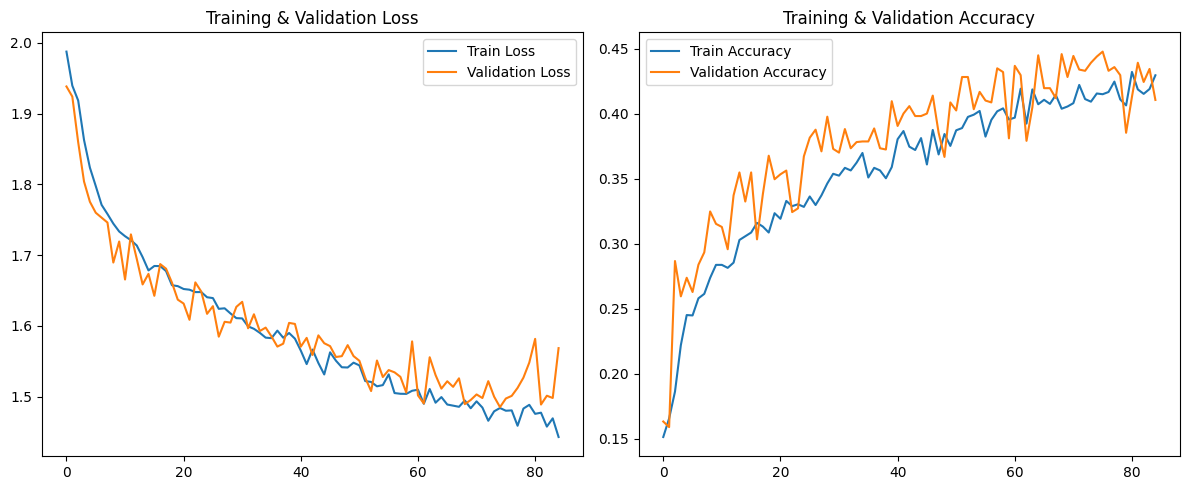

In [9]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

110/110 [==============================] - 92s 837ms/step


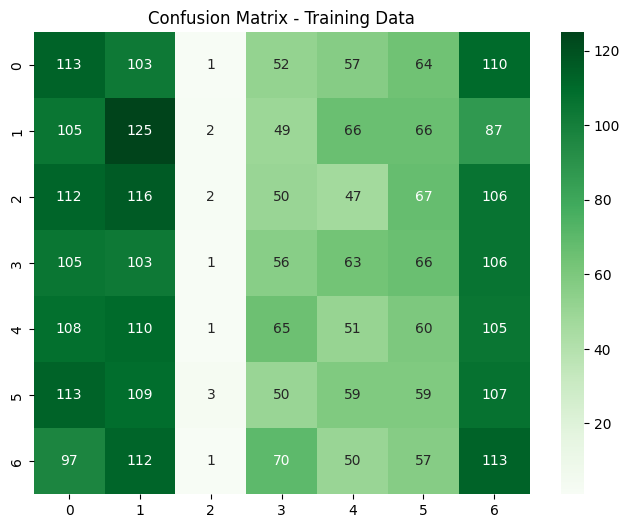

66/66 [==============================] - 29s 440ms/step


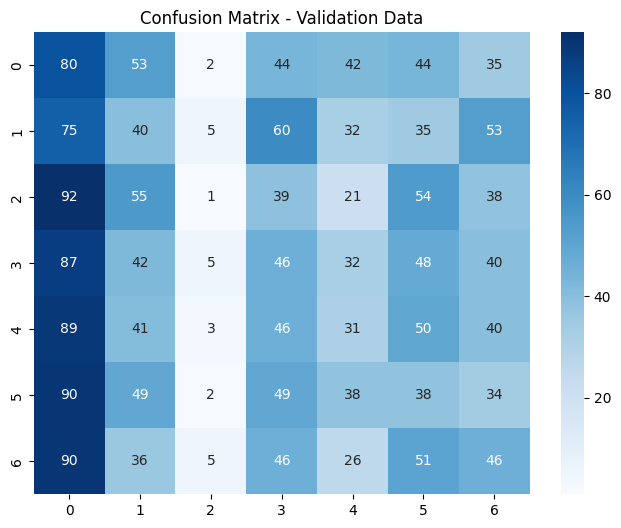

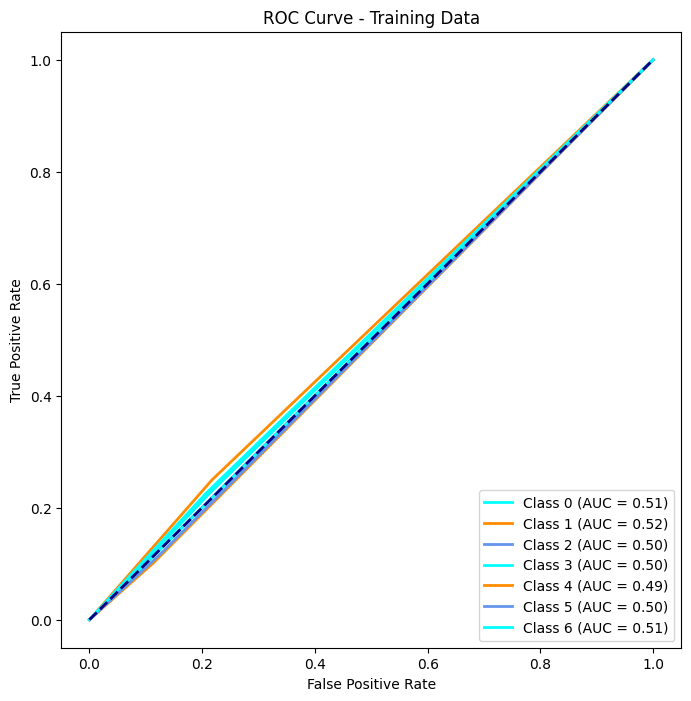

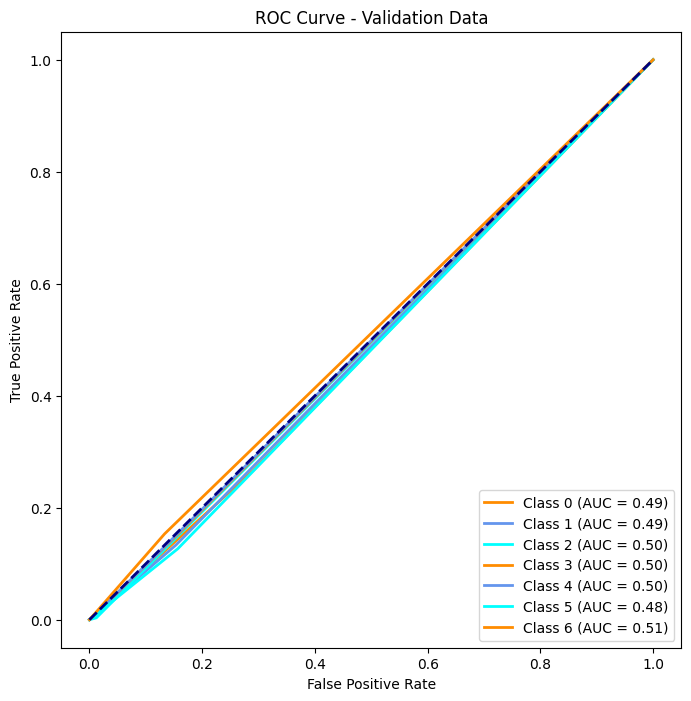

In [10]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()
